In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from deside.utility import set_fig_style, do_pca_analysis
from deside.utility.read_file import ReadH5AD, ReadExp

set_fig_style(font_family='Arial', font_size=8)

2024-01-06 15:21:43.241473: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-06 15:21:43.412363: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-06 15:21:44.108462: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-01-06 15:21:44.108557: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such 

In [2]:
dataset_dir = r'../datasets/simulated_bulk_cell_dataset_subtypes_all_range/'
fig_dir = './fig1/'
d1_file_path = os.path.join(dataset_dir, 'segment_12ds_0.95_n_base100_19cancer_pca_0.9_median_gep', 'simu_bulk_exp_Mixed_N100K_segment_log2cpm1p_filtered_by_high_corr_gene_and_quantile_range_q_0.5_q_99.5.h5ad')
d2_file_path = os.path.join(dataset_dir, 'segment_12ds_no_filtering_n_base100_median_gep', 'simu_bulk_exp_Mixed_N100K_segment_without_filtering_log2cpm1p.h5ad') 
d0_file_path = os.path.join(dataset_dir, 'random_12ds_n_base100', 'simu_bulk_exp_Mixed_N100K_random_log2cpm1p.h5ad')
tcga_file_path = os.path.join('../datasets/TCGA/tpm/merged_tpm.csv')

In [3]:
tcga_tpm = ReadExp(tcga_file_path, exp_type='TPM').get_exp()

In [4]:
tcga_tpm.head(2)

,TRIM71,CCR4,GLB1,TMPPE,CRTAP,SUSD5,FBXL2,UBP1,CLASP2,MATN1,...,GADL1,STT3B,OSBPL10,ZNF860,GPD1L,CMTM8,CMTM7,CMTM6,DYNC1LI1,CNOT10
TCGA-OR-A5LO-01A,0.00,0.017,38.699,0.348,47.470,4.111,6.210,10.764,11.583,0.357,...,0.007,46.981,3.398,0.488,76.426,194.197,17.441,23.289,9.881,10.631
TCGA-P6-A5OG-01A,0.04,0.320,34.088,1.190,113.829,4.699,4.788,28.043,6.925,0.025,...,0.000,97.026,5.841,0.518,11.899,47.232,34.115,60.080,22.208,19.748


In [5]:
def get_pc_simu_bulk_with_tcga(simu_ds_name, ds_file_path, tcga_exp, pca_model_file_path, n_simu_samples=None, n_components=2, t_sne=False, pca_data='simu_bulk'):
    inx2class = {}
    simu_bulk_exp_obj = ReadH5AD(ds_file_path)
    simu_bulk_exp = simu_bulk_exp_obj.get_df()
    if n_simu_samples is not None and n_simu_samples <= simu_bulk_exp.shape[0]:
        simu_bulk_exp = simu_bulk_exp.iloc[range(n_simu_samples), :].copy()
    common_genes = [i for i in simu_bulk_exp.columns.to_list() if i in tcga_exp.columns]
    
    bulk_obj = ReadExp(simu_bulk_exp, exp_type='log_space')
    bulk_obj.align_with_gene_list(gene_list=common_genes)
    bulk_exp = bulk_obj.get_exp()

    tcga_obj = ReadExp(tcga_exp, exp_type='TPM')
    tcga_obj.align_with_gene_list(gene_list=common_genes)
    tcga_obj.to_log2cpm1p()
    tcga_exp_new = tcga_obj.get_exp()
    
    bulk_exp = bulk_exp.sample(tcga_exp_new.shape[0], random_state=42)
    simu_bulk_with_tcga = pd.concat([bulk_exp, tcga_exp_new])
    # simu_bulk_with_tcga = simu_bulk_with_tcga.iloc[range(1500), range(600)].copy()
    print(simu_bulk_with_tcga.shape)
    # print(simu_bulk_with_tcga.head(2))
    if pca_data == 'TCGA':
        pca_model = do_pca_analysis(exp_df=tcga_exp_new, n_components=n_components,
                                pca_result_fp=pca_model_file_path, save_model=True)
    elif pca_data == 'simu_bulk':
        pca_model = do_pca_analysis(exp_df=bulk_exp, n_components=n_components,
                                pca_result_fp=pca_model_file_path, save_model=True)
    else:  # TCGA and simu_bulk
        pca_model = do_pca_analysis(exp_df=simu_bulk_with_tcga, n_components=n_components,
                                    pca_result_fp=pca_model_file_path, save_model=True)
    val_ratio = pca_model.explained_variance_ratio_
    if n_components == 2:
        print('The explained variance ratio: ', val_ratio)
    else:
        print('The total explained variance ratio: ', np.sum(val_ratio))
    pcs = pca_model.transform(simu_bulk_with_tcga)
    # print(pcs)
    if t_sne is False:
        pca_df = pd.DataFrame(pcs[:, range(n_components)], index=simu_bulk_with_tcga.index, columns=[f'PC{i+1}' for i in range(n_components)])
    else:
        X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(pcs)
        pca_df = pd.DataFrame(X_embedded, index=simu_bulk_with_tcga.index, columns=['tSNE_1', 'tSNE_2'])
    for inx in pca_df.index.to_list():
        if inx in bulk_exp.index:
            inx2class[inx] = simu_ds_name
        else:
            inx2class[inx] = 'TCGA'
    pca_df['class'] = pca_df.index.map(lambda x: inx2class[x])
    return pca_df, val_ratio

In [6]:
dataset2color = {'TCGA': 'C5', 'D0': 'C0', 'D1': 'C1', 'D2': 'C2'}

## PCA plot of simulated datasets and TCGA

### D1 and TCGA

In [7]:
simu_ds_name = 'D1'
pca_model_file_path = os.path.join(dataset_dir, f'{simu_ds_name}_PCA.joblib')
d1_tcga_pca, val_ratio = get_pc_simu_bulk_with_tcga(simu_ds_name=simu_ds_name, ds_file_path=d1_file_path, tcga_exp=tcga_tpm, 
                                                    pca_model_file_path=pca_model_file_path, n_components=2, t_sne=False, pca_data='simu_bulk')
print(d1_tcga_pca.shape)
d1_tcga_pca.head(2)

   9028 common genes will be used, 0 genes will be removed.
   9028 common genes will be used, 10684 genes will be removed.
(15398, 9028)
Loading PCA result from file: ../datasets/simulated_bulk_cell_dataset_subtypes_all_range/D1_PCA.joblib
The explained variance ratio:  [0.29839601 0.11283535]
(15398, 3)


,PC1,PC2,class
s_segment_141_2734,17.555952,11.638830,D1
s_segment_149_3776,29.833816,-33.830898,D1


/home/phyxiongx/.conda/envs/ds/lib/python3.8/site-packages/seaborn/axisgrid.py:1760: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


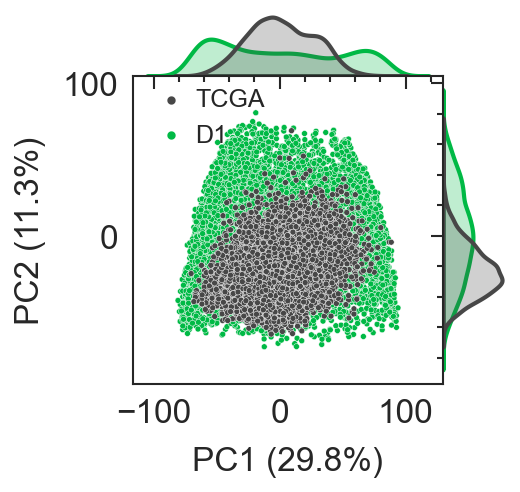

In [8]:
g1 = sns.jointplot(x=f'PC1', y=f'PC2', data=d1_tcga_pca, kind='scatter', 
                   hue='class', s=2, height=1.6, space=0, rasterized=True, palette=dataset2color, hue_order=['TCGA', 'D1'])
g1_ax = g1.ax_joint
g1_ax.set_xticks([-100, 0.0, 100])
g1legend = g1_ax.legend(loc='upper left', fontsize=6, borderpad=0, handletextpad=0)
for _ in g1legend.legendHandles:
    _.set_sizes([1])
# sns.despine(g1_ax)
g1.ax_marg_x.tick_params(axis='x', which='both', top=False)
g1.ax_marg_x.grid(False)
g1.ax_marg_y.tick_params(axis='y', which='both', right=False)
g1.ax_marg_y.grid(False)
g1_ax.set_xlabel(f'PC1 ({val_ratio[0]*100:.1f}%)')
g1_ax.set_ylabel(f'PC2 ({val_ratio[1]*100:.1f}%)')

plt.savefig(os.path.join(fig_dir, f'TCGA_project_to_{simu_ds_name}_PCA.svg'), dpi=300)

### D2 and TCGA

In [9]:
simu_ds_name = 'D2'
pca_model_file_path = os.path.join(dataset_dir, f'{simu_ds_name}_PCA.joblib')
d2_tcga_pca, val_ratio = get_pc_simu_bulk_with_tcga(simu_ds_name=simu_ds_name, ds_file_path=d2_file_path, tcga_exp=tcga_tpm, 
                                                    pca_model_file_path=pca_model_file_path, n_components=2, t_sne=False, pca_data='simu_bulk')
print(d2_tcga_pca.shape)
d2_tcga_pca.head(2)

   17832 common genes will be used, 2 genes will be removed.
   17832 common genes will be used, 1880 genes will be removed.
(15398, 17832)
Loading PCA result from file: ../datasets/simulated_bulk_cell_dataset_subtypes_all_range/D2_PCA.joblib
The explained variance ratio:  [0.22888849 0.1190908 ]
(15398, 3)


,PC1,PC2,class
s_segment_75_748,69.626732,-30.851523,D2
s_segment_80_264,1.715731,43.593861,D2


/home/phyxiongx/.conda/envs/ds/lib/python3.8/site-packages/seaborn/axisgrid.py:1760: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


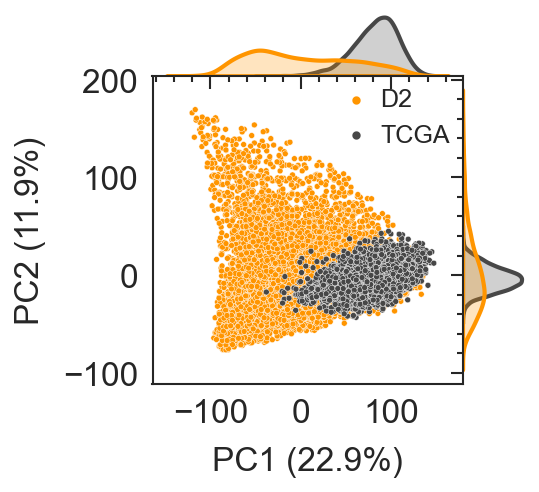

In [10]:
g1 = sns.jointplot(x=f'PC1', y=f'PC2', data=d2_tcga_pca, kind='scatter', 
                   hue='class', s=2, height=1.6, space=0, rasterized=True, palette=dataset2color)
g1_ax = g1.ax_joint
# g1_ax.set_xticks([-5, 0.0, 5.0])
g1legend = g1_ax.legend(loc='upper right', fontsize=6, borderpad=0, handletextpad=0)
for _ in g1legend.legendHandles:
    _.set_sizes([1])
# sns.despine(g1_ax)
g1.ax_marg_x.tick_params(axis='x', which='both', top=False)
g1.ax_marg_x.grid(False)
g1.ax_marg_y.tick_params(axis='y', which='both', right=False)
g1.ax_marg_y.grid(False)
g1_ax.set_xlabel(f'PC1 ({val_ratio[0]*100:.1f}%)')
g1_ax.set_ylabel(f'PC2 ({val_ratio[1]*100:.1f}%)')

plt.savefig(os.path.join(fig_dir, f'TCGA_project_to_{simu_ds_name}_PCA.svg'), dpi=300)

### D0 and TCGA

In [11]:
simu_ds_name = 'D0'
pca_model_file_path = os.path.join(dataset_dir, f'{simu_ds_name}_PCA.joblib')
d0_tcga_pca, val_ratio = get_pc_simu_bulk_with_tcga(simu_ds_name=simu_ds_name, ds_file_path=d0_file_path, tcga_exp=tcga_tpm, 
                                                    pca_model_file_path=pca_model_file_path, n_components=2, t_sne=False, pca_data='simu_bulk')
print(d0_tcga_pca.shape)
d0_tcga_pca.head(2)

   17832 common genes will be used, 2 genes will be removed.
   17832 common genes will be used, 1880 genes will be removed.
(15398, 17832)
Loading PCA result from file: ../datasets/simulated_bulk_cell_dataset_subtypes_all_range/D0_PCA.joblib
The explained variance ratio:  [0.10931924 0.07668699]
(15398, 3)


,PC1,PC2,class
s_random_75_748,-0.791071,15.720829,D0
s_random_80_264,-6.234607,-7.991029,D0


/home/phyxiongx/.conda/envs/ds/lib/python3.8/site-packages/seaborn/axisgrid.py:1760: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


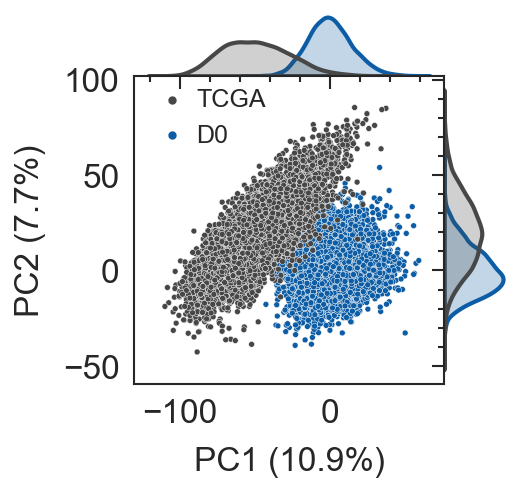

In [12]:
g1 = sns.jointplot(x=f'PC1', y=f'PC2', data=d0_tcga_pca, kind='scatter', 
                   hue='class', s=2, height=1.6, space=0, rasterized=True, palette=dataset2color, hue_order=['TCGA', 'D0'])
g1_ax = g1.ax_joint
# g1_ax.set_xticks([-5, 0.0, 5.0])
g1legend = g1_ax.legend(loc='upper left', fontsize=6, borderpad=0, handletextpad=0)
for _ in g1legend.legendHandles:
    _.set_sizes([1])
# sns.despine(g1_ax)
g1.ax_marg_x.tick_params(axis='x', which='both', top=False)
g1.ax_marg_x.grid(False)
g1.ax_marg_y.tick_params(axis='y', which='both', right=False)
g1.ax_marg_y.grid(False)
g1_ax.set_xlabel(f'PC1 ({val_ratio[0]*100:.1f}%)')
g1_ax.set_ylabel(f'PC2 ({val_ratio[1]*100:.1f}%)')

plt.savefig(os.path.join(fig_dir, f'TCGA_project_to_{simu_ds_name}_PCA.svg'), dpi=300)